In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose

# Set some plotting defaults for better visuals
sns.set_style('whitegrid')
plt.style.use('fivethirtyeight')
plt.rcParams['figure.figsize'] = (15, 10)

In [31]:
train_df = pd.read_csv(r'rossmann-store-sales/train.csv', low_memory=False, parse_dates=['Date'])
store_df = pd.read_csv(r'rossmann-store-sales/store.csv')

# Merge the train and store datasets on the 'Store' column
df = pd.merge(train_df, store_df, on='Store')
print("Data loaded and merged successfully.")
print(df.head())

C:\Users\ravik\AppData\Local\Temp\ipykernel_13444\3895949296.py:1: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  train_df = pd.read_csv(r'rossmann-store-sales/train.csv', low_memory=False, parse_dates=['Date'])


Data loaded and merged successfully.
   Store  DayOfWeek       Date  Sales  Customers  Open  Promo StateHoliday  \
0      1          5 2015-07-31   5263        555     1      1            0   
1      2          5 2015-07-31   6064        625     1      1            0   
2      3          5 2015-07-31   8314        821     1      1            0   
3      4          5 2015-07-31  13995       1498     1      1            0   
4      5          5 2015-07-31   4822        559     1      1            0   

   SchoolHoliday StoreType Assortment  CompetitionDistance  \
0              1         c          a               1270.0   
1              1         a          a                570.0   
2              1         a          a              14130.0   
3              1         c          c                620.0   
4              1         a          a              29910.0   

   CompetitionOpenSinceMonth  CompetitionOpenSinceYear  Promo2  \
0                        9.0                    2008.0 

In [32]:
df.to_excel('rossmann_data_clean.xlsx', index=False)

In [33]:
print("\nCleaning and preprocessing data...")

# We'll focus on stores that were open and had sales
df = df[(df['Open'] == 1) & (df['Sales'] > 0)].copy()

# Set the 'Date' column as the index, which is standard for time series analysis
#df.set_index('Date', inplace=True)

# Handle missing values in 'CompetitionDistance' by filling with the median
median_dist = df['CompetitionDistance'].median()
df['CompetitionDistance'].fillna(median_dist, inplace=True)
print("Missing values handled.")


Cleaning and preprocessing data...
Missing values handled.


C:\Users\ravik\AppData\Local\Temp\ipykernel_13444\358880471.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['CompetitionDistance'].fillna(median_dist, inplace=True)


In [34]:
# Check for the total number of null values in each column
missing_values = df.isnull().sum()
print(missing_values[missing_values > 0])

CompetitionOpenSinceMonth    268600
CompetitionOpenSinceYear     268600
Promo2SinceWeek              423292
Promo2SinceYear              423292
PromoInterval                423292
dtype: int64


In [35]:
# For columns related to Promo2, fill nulls with 0
for col in ['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval','CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 'CompetitionDistance']:
    if col in df.columns:
        df[col].fillna(0, inplace=True)


print("Missing 'Promo2' related values filled with 0.")

# You can re-run the check to confirm they are filled
missing_values_after = df.isnull().sum()
print("\nMissing values after cleaning:")
print(missing_values_after[missing_values_after > 0])

Missing 'Promo2' related values filled with 0.

Missing values after cleaning:
Series([], dtype: int64)


C:\Users\ravik\AppData\Local\Temp\ipykernel_13444\1487515036.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(0, inplace=True)


In [36]:
# Create new columns for each category in 'StoreType' and 'StateHoliday'
df = pd.get_dummies(df, columns=['StoreType', 'StateHoliday'], prefix=['StoreType', 'StateHoliday'])

# # Display the first few rows to see the new columns
# print(df.head(20))

In [37]:
print(df.head(20))

    Store  DayOfWeek       Date  Sales  Customers  Open  Promo  SchoolHoliday  \
0       1          5 2015-07-31   5263        555     1      1              1   
1       2          5 2015-07-31   6064        625     1      1              1   
2       3          5 2015-07-31   8314        821     1      1              1   
3       4          5 2015-07-31  13995       1498     1      1              1   
4       5          5 2015-07-31   4822        559     1      1              1   
5       6          5 2015-07-31   5651        589     1      1              1   
6       7          5 2015-07-31  15344       1414     1      1              1   
7       8          5 2015-07-31   8492        833     1      1              1   
8       9          5 2015-07-31   8565        687     1      1              1   
9      10          5 2015-07-31   7185        681     1      1              1   
10     11          5 2015-07-31  10457       1236     1      1              1   
11     12          5 2015-07

In [49]:
# Create a dataframe for holidays from your main df
print("Creating custom holidays dataframe...")
public_holidays = df[df['StateHoliday_a'] == True][['Date']].rename(columns={'Date': 'ds'})
public_holidays['holiday'] = 'PublicHoliday'
easter_holidays = df[df['StateHoliday_b'] == True][['Date']].rename(columns={'Date': 'ds'})
easter_holidays['holiday'] = 'Easter'
christmas_holidays = df[df['StateHoliday_c'] == True][['Date']].rename(columns={'Date': 'ds'})
christmas_holidays['holiday'] = 'Christmas'
holidays_df = pd.concat([public_holidays, easter_holidays, christmas_holidays])

Creating custom holidays dataframe...


22:20:02 - cmdstanpy - INFO - Chain [1] start processing


Initializing the final, optimized model...
Fitting the final model...


22:20:02 - cmdstanpy - INFO - Chain [1] done processing


Model fitting complete.

Final Optimized RMSE: 1005.35
Plotting the final forecast...


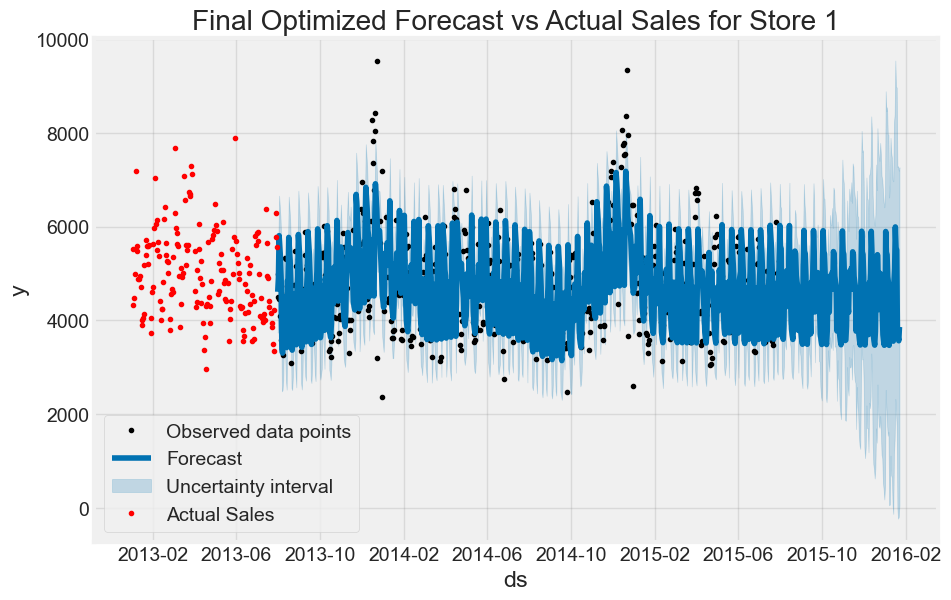

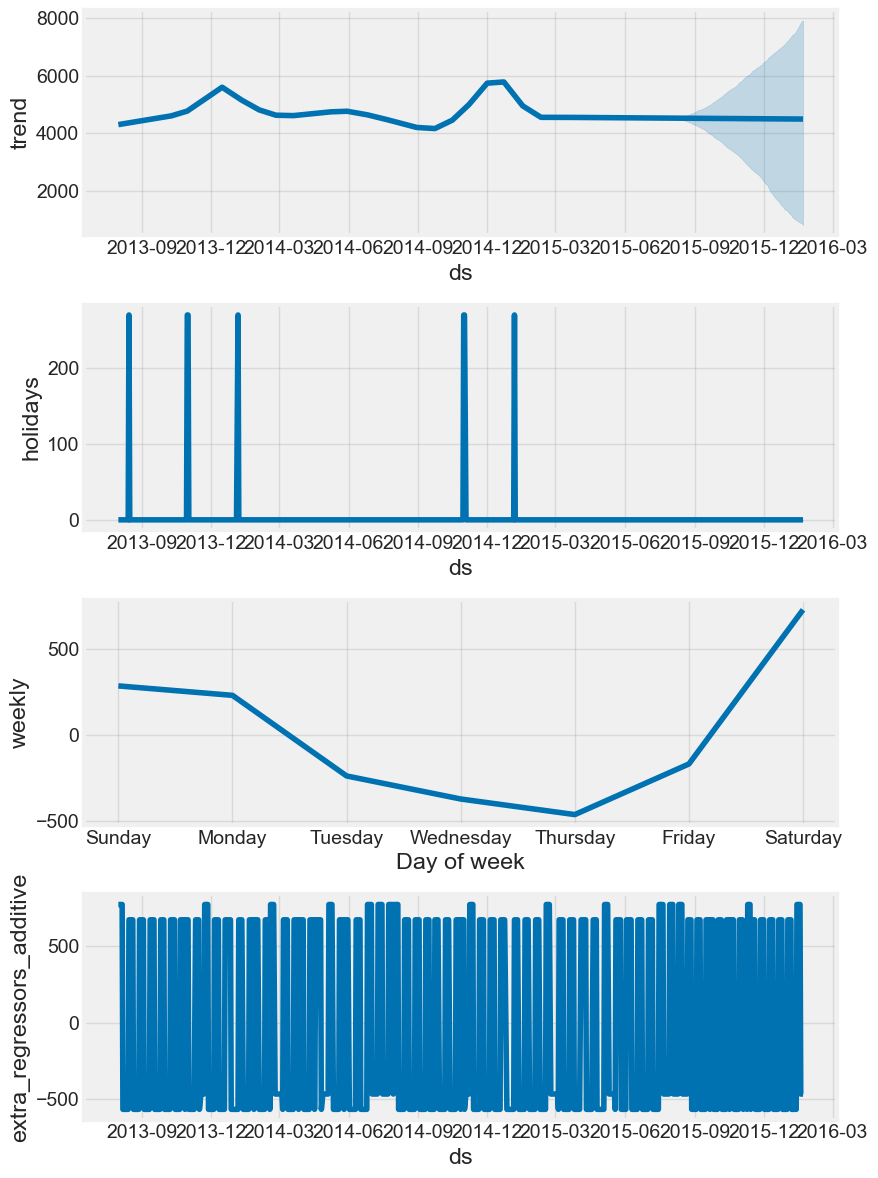

In [52]:
# --- 1. Initialize the Final Model with Best Parameters ---
print("Initializing the final, optimized model...")
best_params = {
    'changepoint_prior_scale': 0.5,
    'seasonality_prior_scale': 30.0,
    'holidays_prior_scale': 10.0,
    'seasonality_mode': 'additive'
}

# Initialize Prophet with the best parameters and holidays
final_model = Prophet(holidays=holidays_df, **best_params)

# Add all the regressors
regressors_to_add = ['Promo', 'SchoolHoliday', 'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d']
for regressor in regressors_to_add:
    final_model.add_regressor(regressor)

# --- 2. Fit the Model on the Training Data ---
# (Using the train_df_prophet variable defined in the previous step)
print("Fitting the final model...")
final_model.fit(train_df_prophet)
print("Model fitting complete.")

# --- 3. Make and Evaluate Predictions ---
# Create a future dataframe for the validation period
future_dates = final_model.make_future_dataframe(periods=validation_period_len)
for regressor in regressors_to_add:
    future_dates[regressor] = store1_regressors[regressor].values

# Generate the forecast
final_forecast = final_model.predict(future_dates)

# Calculate final RMSE
actuals = validation_df_prophet['y']
predictions = final_forecast['yhat'].iloc[-validation_period_len:]
final_rmse = np.sqrt(mean_squared_error(actuals, predictions))

print(f"\nFinal Optimized RMSE: {final_rmse:.2f}")

# --- 4. Visualize the Final Forecast ---
print("Plotting the final forecast...")

# Plot the forecast against the actual sales in the validation period
fig = final_model.plot(final_forecast)
ax = fig.gca()
ax.plot(validation_df_prophet['ds'], validation_df_prophet['y'], 'r.', label='Actual Sales')
ax.set_title('Final Optimized Forecast vs Actual Sales for Store 1')
ax.legend()
plt.show()

# Plot the components
fig2 = final_model.plot_components(final_forecast)
plt.show()

In [54]:
# 1. Import the necessary function
from sklearn.metrics import mean_squared_error
import numpy as np

# 2. Prepare the data for comparison
# Isolate the actual sales values from the validation period
actuals = validation_df_prophet['y']

# Isolate the predicted values from the forecast for the same period
# The forecast dataframe contains predictions for the entire history, so we need the last N rows
predictions = final_forecast['yhat'].iloc[-len(actuals):]

# 3. Calculate and Print the RMSE
mse = mean_squared_error(actuals, predictions)
rmse = np.sqrt(mse)

print(f"The Root Mean Squared Error (RMSE) for the Prophet model is: {rmse:.2f}")

The Root Mean Squared Error (RMSE) for the Prophet model is: 1005.35


In [45]:
import pandas as pd
from prophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import numpy as np
import itertools

# ==============================================================================
# 1. SETUP, DATA LOADING, AND PREPROCESSING
# ==============================================================================
# --- Load and Merge Data ---
print("Loading and merging data...")
train_df = pd.read_csv(r'rossmann-store-sales/train.csv', low_memory=False)
store_df = pd.read_csv(r'rossmann-store-sales/store.csv')
df = pd.merge(train_df, store_df, on='Store')

# --- Cleaning and Feature Engineering ---
print("Cleaning data and creating features...")
df['Date'] = pd.to_datetime(df['Date'])
df = df[(df['Open'] == 1) & (df['Sales'] > 0)].copy()

# Fill missing values for Promo2 and Competition
for col in ['Promo2SinceWeek', 'Promo2SinceYear', 'PromoInterval','CompetitionOpenSinceMonth','CompetitionOpenSinceYear', 'CompetitionDistance']:
    if col in df.columns:
        df[col].fillna(0, inplace=True)

# --- One-Hot Encoding ---
print("Applying one-hot encoding...")
df = pd.get_dummies(df, columns=['StoreType', 'StateHoliday'], prefix=['StoreType', 'StateHoliday'])

# --- Create Custom Holidays Dataframe ---
print("Creating custom holidays dataframe...")
public_holidays = df[df['StateHoliday_a'] == True][['Date']].rename(columns={'Date': 'ds'})
public_holidays['holiday'] = 'PublicHoliday'
easter_holidays = df[df['StateHoliday_b'] == True][['Date']].rename(columns={'Date': 'ds'})
easter_holidays['holiday'] = 'Easter'
christmas_holidays = df[df['StateHoliday_c'] == True][['Date']].rename(columns={'Date': 'ds'})
christmas_holidays['holiday'] = 'Christmas'
holidays_df = pd.concat([public_holidays, easter_holidays, christmas_holidays])


# ==============================================================================
# 2. DATA PREPARATION FOR PROPHET MODEL
# ==============================================================================
print("\nPreparing data for Prophet model...")
# Select data for Store 1
model_df = df[df['Store'] == 1][['Date', 'Sales']].rename(columns={'Date': 'ds', 'Sales': 'y'})

# Define regressors
regressors_to_add = ['Promo', 'SchoolHoliday', 'StoreType_a', 'StoreType_b', 'StoreType_c', 'StoreType_d']

# Create a filtered dataframe with just the regressors for Store 1
store1_regressors = df[df['Store'] == 1][regressors_to_add]

# Add regressors to the main model dataframe
for regressor in regressors_to_add:
    model_df[regressor] = store1_regressors[regressor].values

# --- Train/Validation Split (This is where the variables are correctly defined) ---
validation_period_len = len(df[(df['Store'] == 1) & (df['Date'] >= '2015-01-01')])
train_df_prophet = model_df[:-validation_period_len]
validation_df_prophet = model_df[-validation_period_len:]


# ==============================================================================
# 3. GRID SEARCH FOR HYPERPARAMETER TUNING
# ==============================================================================
# --- Define the Parameter Grid ---
param_grid = {
    'changepoint_prior_scale': [0.05, 0.1, 0.5],
    'seasonality_prior_scale': [10.0, 20.0, 30.0],
    'holidays_prior_scale': [10.0, 20.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

# --- Set up Variables to Store Best Results ---
best_params = None
lowest_rmse = float('inf')

# --- Grid Search Loop ---
print(f"\nStarting grid search... testing {len(all_params)} combinations.")

for params in all_params:
    # Initialize and Fit the Model
    model = Prophet(holidays=holidays_df, **params)
    for regressor in regressors_to_add:
        model.add_regressor(regressor)

    model.fit(train_df_prophet)

    # Make Predictions
    future_dates = model.make_future_dataframe(periods=validation_period_len)
    for regressor in regressors_to_add:
        future_dates[regressor] = store1_regressors[regressor].values

    forecast = model.predict(future_dates)

    # Evaluate the Model
    actuals = validation_df_prophet['y']
    predictions = forecast['yhat'].iloc[-validation_period_len:]

    rmse = np.sqrt(mean_squared_error(actuals, predictions))

    # Store the Best Results
    if rmse < lowest_rmse:
        lowest_rmse = rmse
        best_params = params

    # Optional: print progress
    # print(f"Tested params: {params} -> RMSE: {rmse:.2f}")

# --- Print the Final Results ---
print("\nGrid search complete!")
print(f"Best Parameters Found: {best_params}")
print(f"Lowest RMSE Achieved: {lowest_rmse:.2f}")

Loading and merging data...
Cleaning data and creating features...


C:\Users\ravik\AppData\Local\Temp\ipykernel_13444\1413522257.py:19: UserWarning: Parsing dates in %d-%m-%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'])
C:\Users\ravik\AppData\Local\Temp\ipykernel_13444\1413522257.py:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(0, inplace=True)


Applying one-hot encoding...
Creating custom holidays dataframe...

Preparing data for Prophet model...

Starting grid search... testing 36 combinations.


21:59:18 - cmdstanpy - INFO - Chain [1] start processing
21:59:18 - cmdstanpy - INFO - Chain [1] done processing
21:59:19 - cmdstanpy - INFO - Chain [1] start processing
21:59:19 - cmdstanpy - INFO - Chain [1] done processing
21:59:20 - cmdstanpy - INFO - Chain [1] start processing
21:59:20 - cmdstanpy - INFO - Chain [1] done processing
21:59:20 - cmdstanpy - INFO - Chain [1] start processing
21:59:20 - cmdstanpy - INFO - Chain [1] done processing
21:59:21 - cmdstanpy - INFO - Chain [1] start processing
21:59:21 - cmdstanpy - INFO - Chain [1] done processing
21:59:21 - cmdstanpy - INFO - Chain [1] start processing
21:59:21 - cmdstanpy - INFO - Chain [1] done processing
21:59:22 - cmdstanpy - INFO - Chain [1] start processing
21:59:22 - cmdstanpy - INFO - Chain [1] done processing
21:59:22 - cmdstanpy - INFO - Chain [1] start processing
21:59:22 - cmdstanpy - INFO - Chain [1] done processing
21:59:23 - cmdstanpy - INFO - Chain [1] start processing
21:59:23 - cmdstanpy - INFO - Chain [1]


Grid search complete!
Best Parameters Found: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 30.0, 'holidays_prior_scale': 10.0, 'seasonality_mode': 'additive'}
Lowest RMSE Achieved: 1005.35


In [55]:
import pickle

# --- Save the Final Model to a File ---
# 'final_model' is the variable holding your trained Prophet model
# 'wb' means we are writing to the file in binary mode
with open('prophet_model.pkl', 'wb') as f:
    pickle.dump(final_model, f)

print("Model saved successfully to 'prophet_model.pkl'")

Model saved successfully to 'prophet_model.pkl'
